### Prérequis à installer

In [1]:
#!pip install kaggle

In [2]:
#!conda uninstall python-graphviz
#!conda uninstall graphviz
#!pip install dtreeviz

In [ ]:
#!pip install treeinterpreter
#!pip install waterfallcharts

### Librairies utilisées dans cette session

In [3]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai2.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

In [5]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

### Télécharger les données de la compétition Kaggle

Le jeu de données que nous utiliserons dans ce chapitre est uniquement disponible auprès de Kaggle. Vous devez donc vous inscrire à Kaggle, puis vous rendre sur la [page du concours "Bulldozers"](https://www.kaggle.com/c/bluebook-for-bulldozers/data). Sur cette page, cliquez sur "règles", puis sur "je comprends et j'accepte". (Bien que le concours soit terminé et que vous ne vous inscriviez pas, vous devez encore accepter le règlement pour pouvoir télécharger les données).

Le moyen le plus simple de télécharger des ensembles de données Kaggle est d'utiliser l'API Kaggle. Vous pouvez l'installer à l'aide de pip en l'exécutant dans une cellule de votre notebook :

```
!pip install kaggle
```

Vous avez besoin d'une clé d'API pour utiliser l'API Kaggle ; pour en obtenir une, allez dans "mon compte" sur le site web Kaggle, et cliquez sur "créer une nouvelle clé d'API". Cela permettra d'enregistrer un fichier appelé kaggle.json sur votre PC. Nous devons le créer sur votre serveur GPU. Pour ce faire, ouvrez le fichier que vous avez téléchargé, copiez son contenu et collez-le dans '' ci-dessous, par exemple : creds = '{"username" : "xxx", "key" : "xxx"}' :

In [6]:
# https://www.kaggle.com/yourname/account 
# => Create New API Token 
# => Télécharger le fichier kaggle.json
# => copier le contenu du fichier (1 ligne) ci-dessous

In [7]:
creds = '{"username":"copy your username here","key":"copy your api key here"}'

In [8]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

In [9]:
path = URLs.path('bluebook')
path

Path('/storage/archive/bluebook')

In [10]:
from kaggle import api

if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

In [11]:
path.ls(file_type='text')

(#7) [Path('/storage/archive/bluebook/Valid.csv'),Path('/storage/archive/bluebook/Test.csv'),Path('/storage/archive/bluebook/Machine_Appendix.csv'),Path('/storage/archive/bluebook/median_benchmark.csv'),Path('/storage/archive/bluebook/ValidSolution.csv'),Path('/storage/archive/bluebook/random_forest_benchmark_test.csv'),Path('/storage/archive/bluebook/TrainAndValid.csv')]

# Modélisation de données structurées

On s'intéresse dans cette leçon aux données "structurées", fournies sous forme de tableau.

Les valeurs de chaque colonne représentent une caractéristique distincte bien identifiée.

Objectif : prédire les valeurs d'une colonne en fonction des valeurs des autres colonnes.

## Variables continues et Catégories

Lorsque les données sont fournies sous forme de tableau structuré :
- certaines colonnes contiennent des valeurs numériques, comme "revenu"
- certaines colonnes contiennent des valeurs textuelles, comme "profession"

Les colonnes numériques mesurent des **grandeurs continues qui peuvent prendre une infinité de valeurs** :
- **continuous variables**

Les colonnes textuelles désignent des catégories, avec une **liste finie de valeurs possibles** :
- **categorical variables**

Les libellés qui désignent des catégories doivent être convertis en nombres avant d'être utilisés pour entrainer un modèle de machine learning.

Un appelle "vocabulaire" la liste finie des catégories présentes dans le jeu de données (par exemple une liste de professions triées dans l'ordre alphabétique).

On peut représenter chaque catégorie par un nombre unique, par exemple le numéro de la catégorie dans les liste finie des valeurs possibles. Mais ce nombre n'aurait aucun rapport avec l'objet ou le concept qu'il représente. Deux professions totalement différentes peuvent se retrouver très proches dans l'ordre alphabétique ...

Comme on va la voir dans cette session, cette approche ne pose pas de problème lorsqu'on utilise des arbres de décision.

En revanche, si on met en oeuvre un modèle de type deep learning, on préfère donc les représenter sous forme d'une liste de paramètres appris lors de l'entrainement (**embedding**), comme on l'a fait dans la session précédente pour les utilisateurs et les films dans notre modèle de recommandation :
- chaque catégorie est représentée par une série de nombres
- chaque nombre de cette série correspond à une caractéristique latente de la catégorie
- ces nombres sont initialisés de manière aléatoire et font partie des paramètres du modèle
- ils sont ajustés progressivement dans la boucle d'apprentissage de manière à réduire l'erreur de prédiction

En fin d'apprentissage, deux catégories conceptuellement "proches" sont dotées de représentations numériques similaires, 

## Au-delà du Deep Learning

La plupart des cours de machine learning vous proposent des dizaines d'algorithmes différents, avec une brève description technique des mathématiques qui les sous-tendent et peut-être un exemple simpliste. L'énorme éventail de techniques présentées vous laisse perplexe et vous ne comprenez pas vraiment comment les appliquer.

La bonne nouvelle, c'est que le machine learning moderne peut se résumer à deux techniques clés qui sont applicables dans presque tous les cas. Des études récentes ont montré que la grande majorité des jeux de données de données peuvent être modélisés de manière optimale avec seulement deux méthodes :

- Des ensembles d'**arbres de décision** (c'est-à-dire des forêts aléatoires - **Random Forests** - et des **Gradient Boosted Machines**), principalement pour les données structurées (comme celles que l'on peut trouver dans un tableau de base de données dans la plupart des entreprises)

- Des **réseaux de neurones multicouches** entrainés par SGD (**Deep Learning**), principalement pour les données non structurées (telles que l'audio, les images et le langage naturel)

Bien que le deep learning soit presque toujours nettement supérieur pour les données non structurées, ces deux approches tendent à donner des résultats assez similaires pour de nombreux problèmes de données structurées. 

Les ensembles d'arbres de décision ont tendance à s'entraîner plus rapidement, sont souvent plus faciles à interpréter, ne nécessitent pas de matériel GPU spécial pour l'inférence à grande échelle, et requièrent souvent moins de réglage des hyperparamètres. 

Ils sont populaires depuis bien plus longtemps que le deep learning, de sorte qu'il existe un écosystème plus mature pour l'outillage et la documentation qui les entoure.

Plus important encore, l'étape critique de l'interprétation d'un modèle de données tabulaires est nettement plus facile pour les ensembles d'arbres de décision. Il existe des outils et des méthodes pour répondre aux questions pertinentes. Par exemple, quelles colonnes de l'ensemble de données étaient les plus importantes pour vos prédictions ? Comment sont-elles liées à la variable dépendante ? Comment interagissent-elles les unes avec les autres ? Et quelles caractéristiques particulières étaient les plus importantes pour une observation particulière ?

Par conséquent, les ensembles d'arbres de décision constituent notre première approche pour l'analyse d'un jeu de données tabulaires (structurées).

L'exception à cette ligne directrice est lorsque le jeu de données remplit l'une de ces conditions :
- Il existe des variables de type catégorie avec une cardinalité très élevée ("cardinalité" fait référence au nombre de niveaux discrets possibles dans une catégorie, une catégorie avec une cardinalité très élevée serait par exemple un code postal, qui peut prendre des milliers de niveaux possibles)
- Certaines colonnes contiennent des données qui seraient mieux comprises avec un réseau de neurones, comme des données textuelles en langage naturel.

En pratique, pour les jeux de données qui répondent à ces conditions exceptionnelles, nous testons toujours les deux techniques: les ensembles d'arbres de décision et le deep learning, pour voir ce qui fonctionne le mieux. 

Il était fortement probable que le deep learning donne de bons résultats dans notre exemple de filtrage collaboratif, car nous avions au moins deux variables de type catégorie avec une cardinalité importante : les utilisateurs et les films. Mais en pratique, les choses ont tendance à être moins tranchées et il y aura souvent un mélange de variables de type catégorie à haute et basse cardinalité et de variables continues.

Nous avons utilisé jusqu'ici PyTorch et fastai pour créer des modèles de deep learning.

Pour créer des ensembles d'arbres de décision, nous nous appuierons largement sur une bibliothèque appelée **scikit-learn** (aussi appelée sklearn). Scikit-learn est une bibliothèque populaire pour créer des modèles de machine learning en utilisant des approches qui ne sont pas couvertes par le deep learning. 

En outre, nous devrons faire du traitement de données tabulaires et des requêtes sur ces données, nous utiliserons donc la bibliothèque **Pandas**. 

Enfin, nous aurons également besoin de **numpy**, car c'est la principale bibliothèque de programmation numérique sur laquelle s'appuient à la fois sklearn et Pandas.

## Le jeu de données

Nous allons prendre pour exemple le jeu de données de la compétition Kaggle "[Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data)" : "Le but de ce concours est de prévoir le prix de vente d'un engin de chantier d'occasion aux enchères, en fonction de son utilisation, du type d'engin et de sa configuration. Les données proviennent de la publication des résultats des enchères précédentes et comprennent des informations sur l'utilisation et les configurations des engins".

Il s'agit d'un type de données et d'un problème de prédiction très courant, et similaire à ce que vous pouvez rencontrer dans de vrais projets sur votre lieu de travail. Il peut être téléchargé sur Kaggle, un site web qui organise des concours de sciences des données.

### Explorer les données

Kaggle fournit des informations sur certains des champs de notre jeu de données. La documentation explique que les principaux champs du fichier train.csv sont :

- SalesID: : L'identifiant unique de la vente.
- MachineID: : L'identifiant unique d'un engin. Un engin peut être vendu plusieurs fois.
- saleprice: : Le montant pour lequel l'negin a été vendu aux enchères (uniquement fourni dans train.csv).
- saledate: : La date de la vente.

In [12]:
%time df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

CPU times: user 3.16 s, sys: 457 ms, total: 3.62 s
Wall time: 3.65 s


In [13]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [14]:
len(df)

412698

In [15]:
df.memory_usage().sum()/1024/1024

166.87782287597656

In [16]:
df["SalePrice"].head()

0    66000.0
1    57000.0
2    10000.0
3    38500.0
4    11000.0
Name: SalePrice, dtype: float64

In [17]:
df["SalePrice"].describe()

count    412698.000000
mean      31215.181414
std       23141.743695
min        4750.000000
25%       14500.000000
50%       24000.000000
75%       40000.000000
max      142000.000000
Name: SalePrice, dtype: float64

In [18]:
df['ProductSize'].head()

0       NaN
1    Medium
2       NaN
3     Small
4       NaN
Name: ProductSize, dtype: object

In [19]:
df['ProductSize'].iloc[1], type(df['ProductSize'].iloc[1])

('Medium', str)

In [20]:
df['ProductSize'].isna().head()

0     True
1    False
2     True
3    False
4     True
Name: ProductSize, dtype: bool

In [21]:
df['ProductSize'][~df['ProductSize'].isna()].head()

1            Medium
3             Small
6    Large / Medium
8              Mini
9             Large
Name: ProductSize, dtype: object

In [22]:
len(df['ProductSize'][~df['ProductSize'].isna()])/len(df['ProductSize'])

0.4751488982258213

In [23]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [24]:
df['ProductSize'].memory_usage()/1024

3224.328125

In [25]:
df['ProductSize'] = df['ProductSize'].astype('category')

In [26]:
df['ProductSize'].memory_usage()/1024

403.353515625

In [27]:
df['ProductSize'].head()

0       NaN
1    Medium
2       NaN
3     Small
4       NaN
Name: ProductSize, dtype: category
Categories (6, object): [Compact, Large, Large / Medium, Medium, Mini, Small]

In [28]:
df['ProductSize'].cat.categories

Index(['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small'], dtype='object')

In [29]:
df['ProductSize'].cat.codes.head()

0   -1
1    3
2   -1
3    5
4   -1
dtype: int8

In [30]:
df['ProductSize'].iloc[1], type(df['ProductSize'].iloc[1])

('Medium', str)

In [31]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [32]:
df['ProductSize'].cat.codes.head()

0   -1
1    2
2   -1
3    3
4   -1
dtype: int8

Le choix de la mesure de l'erreur à optimiser est une partie importante de la mise en place du projet. Dans de nombreux cas, le choix d'une bonne mesure nécessitera plus que la simple sélection d'une fonction qui existe déjà. Il s'agit plutôt d'un processus de conception. Vous devez réfléchir attentivement à la mesure ou à l'ensemble de mesures qui reflètent réellement la qualité du modèle qui vous importe.

Dans ce cas, Kaggle nous indique la mesure à utiliser : root mean squared **log** error (RMSLE) entre les prix réels et les prix prévus des enchères. Cette mesure nous permet de mesurer **l'erreur relative** par rapport au prix de vente. 1000 dollars d'erreurs n'ont pas le même impact pour une vente à 5000 dollars ou pour une vente à 140 000 dollars.

Pour l'utiliser : nous prenons le logarithme du prix de vente, de sorte que l'application de la fonction RMSE à cette valeur nous donne la mesure sur laquelle les soumissions à la compétition Kaggle sont évaluées.

In [33]:
dep_var = 'SalePrice'

In [34]:
df[dep_var] = np.log(df[dep_var])

In [35]:
df[dep_var].describe()

count    412698.000000
mean         10.105977
std           0.695005
min           8.465900
25%           9.581904
50%          10.085809
75%          10.596635
max          11.863582
Name: SalePrice, dtype: float64

## Decision Trees

Les ensembles d'arbres de décision, comme leur nom l'indique, reposent sur des arbres de décision. Un arbre de décision pose une série de questions binaires (c'est-à-dire avec des réponses oui ou non) sur les données. Après chaque question, les données de cette partie de l'arbre sont réparties entre une branche "oui" et une branche "non".

Cette séquence de questions constitue une procédure permettant de prendre n'importe quelle donnée, qu'il s'agisse d'un élément du jeu d'entrainement ou d'un élément fourni en production, et de l'affecter à un groupe. En d'autres termes, après avoir posé les questions et y avoir répondu, nous pouvons dire que l'élément appartient au même groupe que tous les autres éléments du jeu d'entrainement qui ont donné le même ensemble de réponses aux questions. 

Mais à quoi cela sert-il ? Le but de notre modèle est de prédire les valeurs des éléments, et non de les répartir en groupes à partir de l'ensemble des données de formation. L'intérêt est que nous pouvons maintenant attribuer une prédiction pour chacun de ces groupes - pour la régression, nous prenons la moyenne cible des éléments du groupe.

Voyons comment trouver les bonnes questions à poser. Bien sûr, nous ne voudrions pas avoir à créer toutes ces questions nous-mêmes - c'est à cela que servent les ordinateurs ! Les étapes de base pour former un arbre de décision peuvent être écrites très facilement :

1. Examinez chaque colonne de l'ensemble de données à tour de rôle.
2. Pour chaque colonne, examinez chaque niveau (valeur distincte) de cette colonne à tour de rôle .
3. Partitionnez les données en deux groupes, selon qu'elles sont supérieures ou inférieures à cette valeur.
4. Trouvez le prix de vente moyen pour chacun de ces deux groupes, et voyez dans quelle mesure il est proche du prix de vente réel de chacun des équipements de ce groupe. Autrement dit, considérez cela comme un "modèle" très simple dans lequel nos prévisions sont simplement le prix de vente moyen du groupe d'articles.
5. Après avoir parcouru toutes les colonnes et tous les niveaux possibles pour chacun, choisissez le point de rupture qui a donné les meilleures prédictions en utilisant ce modèle simple.
6. Nous avons maintenant deux groupes différents pour nos données, sur la base de ce point de partage sélectionné. Traitez chacun d'eux comme un ensemble de données distinct et trouvez la meilleure répartition pour chacun en revenant à l'étape 1 pour chaque groupe.
7. Continuez ce processus de manière récursive, jusqu'à ce que vous ayez atteint un critère d'arrêt pour chaque groupe - par exemple, arrêtez de diviser un groupe davantage lorsqu'il ne contient que 20 éléments.

Bien que cet algorithme soit assez facile à mettre en œuvre par vous-même (et c'est un bon exercice), nous pouvons gagner du temps en utilisant l'implémentation fournie dans sklearn.

### Gérer les dates

In [36]:
df['saledate'].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

In [37]:
df = add_datepart(df, 'saledate')

In [38]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [39]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [40]:
df[['saleDayofweek', 'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start', 'saleElapsed']].head()

,saleDayofweek,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,3,False,False,False,False,False,False,1163635200
1,4,False,False,False,False,False,False,1080259200
2,3,False,False,False,False,False,False,1077753600
3,3,False,False,False,False,False,False,1305763200
4,3,False,False,False,False,False,False,1248307200


In [41]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

### Utiliser TabularPandas et TabularProc

Créer un jeu d'entrainement et un jeu de validation : 

Si vous regardez la fourchette de dates représentée dans le jeu de données de test, vous découvrirez qu'elle couvre une période de six mois à partir de mai 2012, ce qui est postérieur à n'importe quelle date du jeu de données d'entrainement.

C'est une bonne conception, car l'organisateur du concours veut s'assurer qu'un modèle est capable de prédire l'avenir.  Mais cela signifie que si nous voulons disposer d'un jeu de validation utile, nous voulons aussi que le jeu de validation soit postérieur au jeu d'entrainement. 

Les données d'entraînement Kaggle se terminent en avril 2012, nous définirons donc un jeu d'entraînement plus restreint qui ne comprendra que les données d'entraînement Kaggle d'avant novembre 2011, et nous définirons un jeu de validation comprenant les données d'après novembre 2011.

In [42]:
df['saleYear'].describe()

count    412698.000000
mean       2004.317382
std           5.821090
min        1989.000000
25%        2000.000000
50%        2006.000000
75%        2009.000000
max        2012.000000
Name: saleYear, dtype: float64

In [43]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

Identifier les variables continues et les variables de type catégorie :

In [44]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [45]:
cont[:5]

['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID']

In [46]:
cat[:5]

['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries']

Comment fonctionne cette fonction ?

In [47]:
doc(cont_cat_split)

Nous allons utiliser la classe TabularPandas de fastai, qui encapsule une DataFrame Pandas et fournit des fonctionnalités additionnelles très pratiques pour le machine learning.

Pour initialiser un objet TabularPandas, nous utiliserons deux TabularProc*s*, Categorify et FillMissing. Une TabularProc est comme une transformation qui :
- renvoie exactement le même objet que celui qui lui a été passé, après avoir modifié l'objet en place.
- exécute la transformation une seule fois, immédiatement lorsqu'on lui passe les données, plutôt qu'au fur et à mesure des accès aux données (lazy).

Categorify est un TabularProc qui remplace une colonne par une colonne catégorielle numérique. 

FillMissing est une TabularProc qui remplace les valeurs manquantes par la médiane de la colonne, et crée une nouvelle colonne booléenne dont la valeur est True pour toute ligne où la valeur était manquante.

Ces deux transformations sont nécessaires pour presque tous les ensembles de données tabulaires que vous utiliserez, c'est donc un bon point de départ pour votre traitement des données.

In [48]:
procs = [Categorify, FillMissing]

In [49]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [50]:
len(to.train),len(to.valid)

(404710, 7988)

In [51]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246.0,999089.0,3157.0,121.0,3.0,2004.0,68.0,2006.0,11.0,46.0,16.0,3.0,320.0,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248.0,117657.0,77.0,121.0,3.0,1996.0,4640.0,2004.0,3.0,13.0,26.0,4.0,86.0,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249.0,434808.0,7009.0,121.0,3.0,2001.0,2838.0,2004.0,2.0,9.0,26.0,3.0,57.0,1.077754e+09,9.210340


In [52]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [53]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246.0,11.097410,999089.0,3157.0,...,1,1.163635e+09,1,1
1,1139248.0,10.950807,117657.0,77.0,...,1,1.080259e+09,1,1
2,1139249.0,9.210340,434808.0,7009.0,...,1,1.077754e+09,1,1


In [54]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [55]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

Enregistrer les données préparées :

In [56]:
(path/'to.pkl').save(to)

### Créer un arbre de décision

Charger les données préparées :

In [57]:
%time to = (path/'to.pkl').load()

CPU times: user 17.8 ms, sys: 20.7 ms, total: 38.5 ms
Wall time: 38.1 ms


In [58]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [59]:
type(to.train.xs),type(to.train.y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [60]:
to.train.xs.head()

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,2,958,297,43,...,16.0,3.0,320.0,1.163635e+09
1,2,1737,528,57,...,26.0,4.0,86.0,1.080259e+09
2,1,334,111,0,...,26.0,3.0,57.0,1.077754e+09
3,1,3693,1375,0,...,19.0,3.0,139.0,1.305763e+09
4,3,4229,1527,0,...,23.0,3.0,204.0,1.248307e+09


In [61]:
to.train.y.head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

In [62]:
DecisionTreeRegressor?

In [63]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
%time m.fit(xs, y);

CPU times: user 1.76 s, sys: 1.19 ms, total: 1.76 s
Wall time: 1.76 s


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=4,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

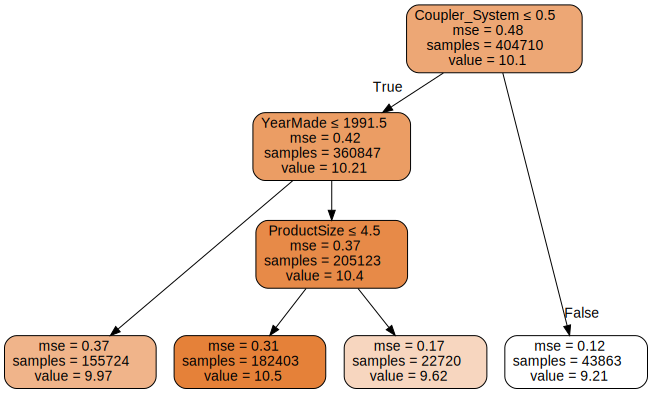

In [64]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

Nous pouvons examiner la même information en utilisation la puissante librairie [dtreeviz](https://explained.ai/decision-tree-viz/) de Terence Parr :

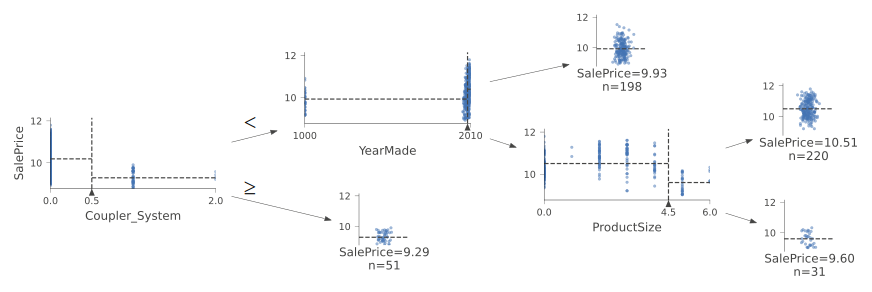

In [65]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [66]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

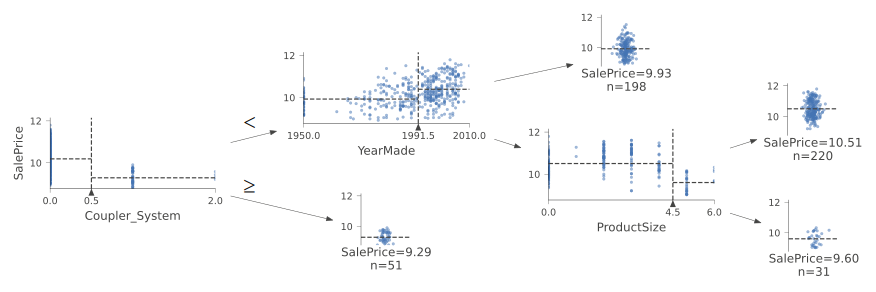

In [67]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [68]:
m = DecisionTreeRegressor()
%time m.fit(xs, y);

CPU times: user 8.8 s, sys: 9.1 ms, total: 8.81 s
Wall time: 8.8 s


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [69]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

Erreur sur le jeu d'entrainement :

In [70]:
m_rmse(m, xs, y)

1e-06

Erreur sur le jeu de validation :

In [71]:
m_rmse(m, valid_xs, valid_y)

0.335193

Oooops ... overfitting !!

In [72]:
m.get_n_leaves(), len(xs)

(324558, 404710)

Logique : nous avons quasiment autant de feuilles dans l'arbre de décision que d'exemples dans le jeu d'entrainement => le modèle a tout simplement appris par coeur toutes les valeurs à prédire ...

Pour éviter ça et préserver la capacité de généralisation du modèle, nous allons créer un arbre de décision contenant au minimum 25 exemples d'entrainement au niveau de chaque feuille :

In [73]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323769)

In [74]:
m.get_n_leaves()

12397

Erreur sur le jeu d'entrainement :

In [75]:
m_rmse(m, xs, y)

0.248593

Erreur sur le jeu de validation :

In [76]:
m_rmse(m, valid_xs, valid_y)

0.323769

La construction d'un arbre de décision est un bon moyen de créer un modèle de nos données. Il est très flexible, car il peut clairement traiter les relations non linéaires et les interactions entre les variables. 

Mais nous pouvons voir qu'il existe un compromis fondamental entre la capacité de généralisation (que nous pouvons obtenir en créant de petits arbres) et la précision du modèle (que nous pouvons obtenir en utilisant de grands arbres).

Alors, comment obtenir le meilleur des deux mondes ?

## Random Forests

En 1994, un an après sa retraite, le professeur Leo Breiman de Berkeley a publié un petit rapport technique intitulé "Bagging Predictors", qui s'est avéré être l'une des idées les plus influentes de l'apprentissage machine moderne.

Voici la procédure que Breiman propose :

1. Choisissez au hasard un sous-ensemble des lignes de vos données.
2. Entrainez un modèle en utilisant ce sous-ensemble.
3. Sauvegardez ce modèle, puis revenez plusieurs fois à l'étape 1. Vous obtiendrez ainsi un certain nombre de modèles entrainés sur des sous-ensembles de lignes différents. 
4. Pour faire une prédiction, faites une prédiction en utilisant tous les modèles, puis prenez la moyenne des prédictions de ces modèles.

Cette procédure est connue sous le nom de **"bagging"**. Elle est basée sur une idée profonde et importante : **bien que chacun des modèles entrainés sur un sous-ensemble des données fasse plus d'erreurs qu'un modèle entrainé sur l'ensemble des données, ces erreurs ne seront pas corrélées entre elles. Différents modèles produiront différentes erreurs. La moyenne de ces erreurs est donc de zéro !** Donc, si nous prenons la moyenne des prédictions de tous les modèles, plus nous avons de modèles plus nous devrions obtenir une prédiction qui se rapproche de la bonne réponse. 

C'est un résultat extraordinaire - cela signifie que nous pouvons améliorer la précision de presque tout type d'algorithme d'apprentissage automatique en l'entraînant plusieurs fois, chaque fois sur un sous-ensemble aléatoire différent des données, et en faisant la moyenne de ses prédictions.

En 2001, Leo Breiman a poursuivi en démontrant que cette approche de la construction de modèles, lorsqu'elle est appliquée aux algorithmes de construction d'arbres de décision, est particulièrement puissante. Il est allé encore plus loin que le simple choix aléatoire de lignes pour l'entraînement de chaque modèle, mais aussi la sélection aléatoire d'un sous-ensemble de colonnes lors du choix de chaque division dans chaque arbre de décision. Il a appelé cette méthode la forêt aléatoire (**random forest**). Aujourd'hui, c'est peut-être la méthode de machine learning la plus utilisée et la plus importante sur le plan pratique.

En substance, une forêt aléatoire est un modèle qui fait la moyenne des prédictions d'un grand nombre d'arbres de décision, qui sont générées en faisant varier aléatoirement divers paramètres qui spécifient quelles données sont utilisées pour entrainer l'arbre et d'autres paramètres de l'arbre. La technique de bagging est une approche de choix pour la création d'ensembles de modèles ("ensembling").

### Créer une Random Forest

Nous pouvons créer une forêt aléatoire tout comme nous avons créé un arbre de décision, sauf que maintenant, nous spécifions également des paramètres qui indiquent :
- combien d'arbres différent doivent constituer l'ensemble de la forêt,
- comment extraire un sous-ensemble des données d'entrainement (lignes à conserver pour entrainer un arbre donné),
- comment extraire un sous-ensemble des champs (colonnes à considérer à chaque point de décision).

Dans la définition de fonction suivante :
- n_estimators définit le nombre d'arbres que nous voulons, 
- max_samples définit le nombre de lignes à échantillonner pour former chaque arbre, 
- max_features définit le nombre de colonnes à échantillonner à chaque point de séparation (où 0,5 signifie "prendre la moitié du nombre total de colonnes"). 

Nous pouvons également spécifier quand arrêter de diviser les nœuds de l'arbre, ce qui limite effectivement la profondeur de l'arbre, en incluant le même paramètre min_samples_leaf que nous avons utilisé dans la dernière section. 

Enfin, nous passons n_jobs=-1 pour dire à sklearn d'utiliser tous les coeurs de notre CPU pour construire les arbres en parallèle. 

En créant une petite fonction pour cela, nous pouvons plus rapidement essayer différentes variations dans le reste de ce chapitre :

In [77]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [78]:
%time m = rf(xs, y);

CPU times: user 1min 22s, sys: 847 ms, total: 1min 23s
Wall time: 16.2 s


In [79]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171142, 0.233165)

Une des propriétés les plus importantes des forêts aléatoires est qu'elles ne sont pas très sensibles aux choix des hyperparamètres, tels que max_features. 

Vous pouvez régler n_estimators sur un nombre aussi élevé que possible en fonction du temps dont vous disposez pour l'entrainement - plus vous avez d'arbres, plus le modèle sera précis.

max_samples peut souvent être laissé à sa valeur par défaut, sauf si vous avez plus de 200 000 points de données, auquel cas le réglage à 200 000 lui permettra de s'entraîner plus rapidement avec peu d'impact sur la précision.

max_features=0,5 et min_samples_leaf=5 ont tous deux tendance à bien fonctionner, bien que les valeurs par défaut de sklearn fonctionnent bien aussi.

On visualise ci-dessous les gains réalisés sur l'erreur de prédiction lorsqu'on ajoute un plus grand nombre d'arbres de décision dans la forêt aléatoire :

In [80]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [81]:
r_mse(preds.mean(0), valid_y)

0.233165

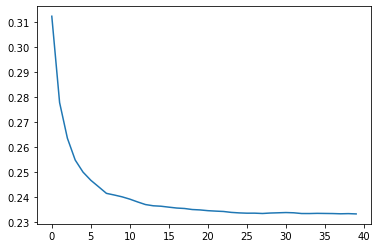

In [82]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

Les performances sur notre jeu de validation sont moins bonnes que celles de notre jeu d'entrainement.

Est-ce une manifestation d'overfitting, ou parce que le jeu de validation couvre une période différente, ou un peu des deux ? 

Avec les informations existantes que nous avons vues, nous ne pouvons pas le dire. Cependant, les forêts aléatoires ont une métrique très astucieuse appelée Out-of-bag error (OOB) qui peut nous aider dans ce domaine (et plus encore !).

Rappelons que dans une forêt aléatoire, chaque arbre est entrainé sur un sous-ensemble différent des données du jeu d'entrainement. L'erreur OOB est un moyen de **mesurer l'erreur de prédiction sur l'ensemble d'entrainement, en incluant dans le calcul de l'erreur de prédiction réalisée sur une ligne uniquement les arbres de décision où cette ligne n'a pas été utilisée pendant l'entrainement**. Cela nous permet d'avoir une première mesure de la capacité de généralisation du modèle, sans avoir besoin d'un ensemble de validation séparé.

Cela est particulièrement avantageux dans les cas où nous ne disposons que d'une petite quantité de données d'entrainement, car cela nous permet de voir si notre modèle a une capacité de généralisation sans avoir à mettre de côté des exemples uniquement pour créer un jeu de validation. 

Les prédictions OOB sont disponibles dans l'attribut oob_prediction_. Notez que nous les comparons aux labels du jeu d'entrainement, car elles sont calculées sur les arbres du jeu d'entrainement.

In [83]:
r_mse(m.oob_prediction_, y)

0.210949

L'erreur Out-of-bag est significativement inférieure à l'erreur sur le jeu de validation, il y a donc un problème plus profond qui limite la capacité d'adaptation du modèle du jeu d'entrainement au jeu de validation (constitué sur une période postérieure).

## Interprétation du modèle

Pour les données structurées, l'interprétation des modèles est particulièrement importante. Pour un modèle donné, les informations qui ont le plus de chance de nous intéresser sont :

1. Quel est notre degré de confiance dans nos prédictions pour un exemple particulier ?
2. Pour réaliser une prédiction sur un exemple donné, quels ont été les facteurs les plus importants, et comment ont-ils influencé cette prédiction ?
3. Quelles colonnes sont les prédicteurs les plus forts, lesquelles pouvons-nous ignorer ?
4. Quelles sont les colonnes qui sont redondantes les unes par rapport aux autres, à des fins de prédiction ?
5. Comment les prédictions varient-elles, alors que nous faisons varier ces colonnes ?

Comme nous le verrons, les forêts aléatoires sont particulièrement bien adaptées pour répondre à ces questions.

### Confiance dans la prédiction - Variance entre les arbres de décision

En général, nous voudrions être plus prudents en utilisant les résultats pour les lignes où les arbres de décision de la forêt donnent des résultats très différents (écarts types plus élevés), par rapport aux cas où ils sont plus cohérents (écarts types plus faibles).

In [84]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [85]:
preds.shape

(40, 7988)

In [86]:
preds_std = preds.std(0)

In [87]:
preds_std[:5]

array([0.24853794, 0.10921896, 0.09565452, 0.23298901, 0.1310355 ])

### Importance relative des caractéristiques - Feature Importance

Le mode de calcul de l'importance de chaque colonne est assez simple mais élégant :
- L'algorithme de calcul de l'importance des caractéristiques passe en boucle dans chaque arbre, puis explore récursivement chaque branche. 
- À chaque branche, il cherche à voir quelle caractéristique a été utilisée pour cette division et dans quelle mesure le modèle s'améliore à la suite de cette division. 
- L'amélioration (pondérée par le nombre de lignes de ce groupe) est ajoutée à la note d'importance de cette caractéristique.
- Cette note est additionnée pour toutes les branches de tous les arbres, et finalement les notes sont normalisées de sorte qu'elles s'additionnent pour donner 1.

Nous pouvons obtenir directement cette information avec sklearn en regardant dans l'attribut feature_importances_ du modèle. 

In [88]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [89]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.178837
6,ProductSize,0.117284
30,Coupler_System,0.112683
7,fiProductClassDesc,0.090630
54,ModelID,0.058224
65,saleElapsed,0.049607
3,fiSecondaryDesc,0.044414
32,Hydraulics_Flow,0.043618
31,Grouser_Tracks,0.032281
1,fiModelDesc,0.031936


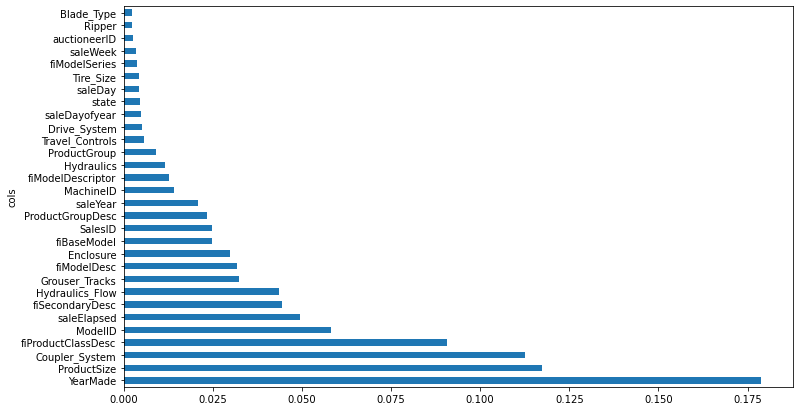

In [90]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Supprimer les variables de moindre importance

Il semble probable que nous pourrions utiliser seulement un sous-ensemble des colonnes en supprimant les variables de faible importance et obtenir tout de même de bons résultats.

Essayons de ne garder que celles dont l'importance est supérieure à 0,005 :

In [91]:
len(xs.columns)

66

In [92]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

22

Seulement 1/3 des colonnes semblent vraiment jouer un rôle dans la prédiction du résultat.

In [93]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [94]:
%time m = rf(xs_imp, y)

CPU times: user 47.2 s, sys: 144 ms, total: 47.3 s
Wall time: 8.85 s


In [95]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.178061, 0.234298)

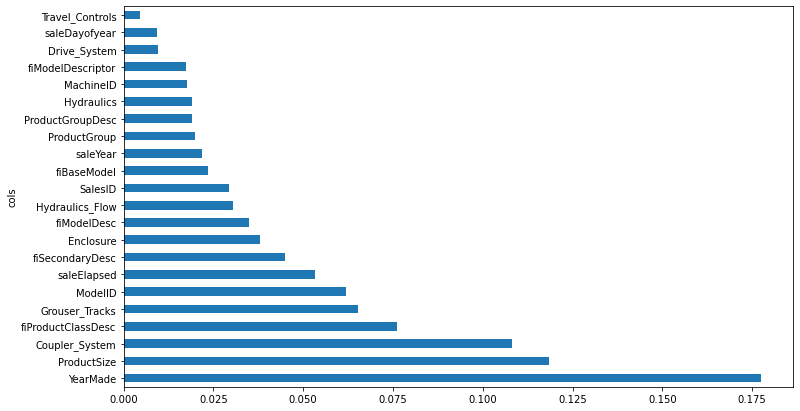

In [96]:
plot_fi(rf_feat_importance(m, xs_imp));

### Supprimer les caractéristiques redondantes

Les paires de variables **les plus similaires** sont trouvées en calculant la métrique "rank correlation", ce qui signifie que toutes les valeurs de chaque colonne sont remplacées par leur rang dans l'ensemble des valeurs triées (c'est-à-dire premier, deuxième, troisième, etc. dans la colonne), puis la corrélation est calculée entre les colonnes.

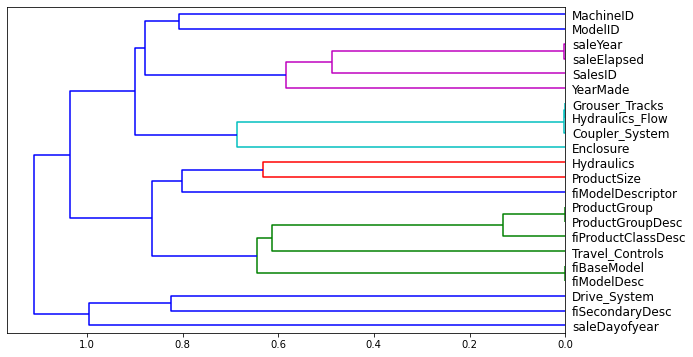

In [97]:
cluster_columns(xs_imp)

Dans ce tableau, les paires de colonnes les plus similaires sont celles qui ont été fusionnées ensemble au début, loin de la "racine" de l'arbre à gauche. Il n'est pas surprenant que les champs ProductGroup  et ProductGroupDesc aient été fusionnés assez tôt, tout comme les champs saleYear et saleElapsed. Ces variables sont si étroitement liées qu'elles sont pratiquement synonymes l'une de l'autre.

Essayons de supprimer certaines de ces caractéristiques étroitement liées pour voir si le modèle peut être simplifié sans nuire à la précision. Tout d'abord, nous créons une fonction qui entraîne rapidement une forêt aléatoire et retourne le **score OOB**, en utilisant un max_samples inférieur et un min_samples_leaf supérieur. 

Le score OOB est un nombre renvoyé par sklearn qui varie entre 1,0 pour un modèle parfait et 0,0 pour un modèle aléatoire. En statistique, il est appelé R^2, bien que les détails ne soient pas importants pour cette explication. Nous n'avons pas besoin qu'il soit très précis - nous allons simplement l'utiliser pour comparer différents modèles, en supprimant certaines des colonnes éventuellement redondantes :

In [98]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Baseline :

In [99]:
get_oob(xs_imp)

0.8782773090316527

Score de prédiction si on enlève unitairement les variables de 4 groupes de variables les plus similaires :

In [100]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8762799453579725,
 'saleElapsed': 0.8730388469468675,
 'ProductGroupDesc': 0.8772803967858384,
 'ProductGroup': 0.8766179003226244,
 'fiModelDesc': 0.874990001359305,
 'fiBaseModel': 0.8751730124748429,
 'Hydraulics_Flow': 0.8768285899125444,
 'Grouser_Tracks': 0.8767315873930076,
 'Coupler_System': 0.8771937491616989}

On essaie de supprimer les 5 variables qui provoquent la baisse de score la plus limitée : 

In [101]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8752433662177672

Bien ! On perd très peu par rapport au modèle avec tous les champs. Créons des DataFrames sans ces colonnes, et sauvegardons-les :

In [102]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [103]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [104]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

In [105]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.179345, 0.235451)

En nous concentrant sur les variables les plus importantes et en supprimant certaines variables redondantes, nous avons considérablement simplifié notre modèle.

### Partial Dependence

Comme nous l'avons vu, les deux indicateurs les plus importants sont ProductSize et YearMade. Nous aimerions comprendre la relation entre ces prédicteurs et le prix de vente. 

Pour ProductSize, il est bon de vérifier d'abord le nombre de valeurs par catégorie (fourni par la méthode Pandas value_counts), pour voir dans quelle mesure chaque catégorie est fréquente :

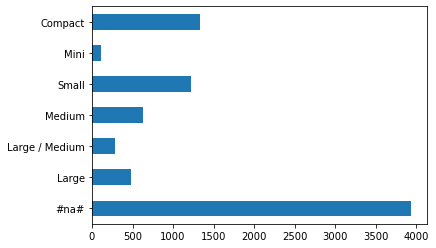

In [106]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

Le groupe le plus important est #na#, qui est l'étiquette que fastai applique aux valeurs manquantes.

Faisons la même chose pour YearMade. Comme il s'agit d'une caractéristique numérique, nous devrons dessiner un histogramme, qui regroupe les valeurs de l'année dans plusieurs groupes distincts :

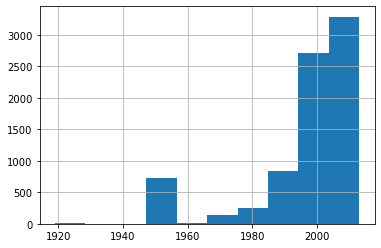

In [107]:
ax = valid_xs_final['YearMade'].hist()

À part la valeur spéciale 1950 que nous avons utilisée pour coder les valeurs des années manquantes, la plupart des données sont postérieures à 1990.

Nous sommes maintenant prêts à examiner les graphiques de **dépendance partielle**. 

Les diagrammes de dépendance partielle tentent de répondre à la question suivante : si une ligne ne variait sur rien d'autre que l'élément en question, quel impact aurait-il sur la variable dépendante (à prédire) ?

Par exemple, quel est l'impact de YearMade sur le prix de vente, toutes choses étant égales par ailleurs ?

Pour répondre à cette question, nous ne pouvons pas nous contenter de prendre le prix de vente moyen de chaque YearMade. Le problème de cette approche est que beaucoup d'autres choses varient également d'une année à l'autre, comme les produits vendus, le nombre de produits équipés de la climatisation, l'inflation, etc. Ainsi, le simple fait de faire la moyenne de toutes les ventes aux enchères ayant le même YearMade permettrait également de saisir l'effet de l'évolution de tous les autres domaines en même temps que le YearMade et la manière dont cette évolution globale a affecté le prix.

Au lieu de cela, nous remplaçons chaque valeur de la colonne YearMade par 1950, puis nous calculons le prix de vente prévu pour chaque vente aux enchères et nous prenons la moyenne de toutes les ventes aux enchères. Nous faisons ensuite la même chose pour 1951, 1952, et ainsi de suite jusqu'à notre dernière année, 2011. Cela permet d'isoler l'effet de la colonne "YearMade" uniquement (même si cela se fait en calculant la moyenne sur certains enregistrements imaginaires où nous attribuons une valeur "YearMade" qui pourrait ne jamais exister en réalité à côté d'autres valeurs).

Avec ces moyennes, nous pouvons ensuite tracer chacune de ces années sur l'axe des x, et chacune des prédictions sur l'axe des y. Il s'agit d'un graphique de dépendance partielle.

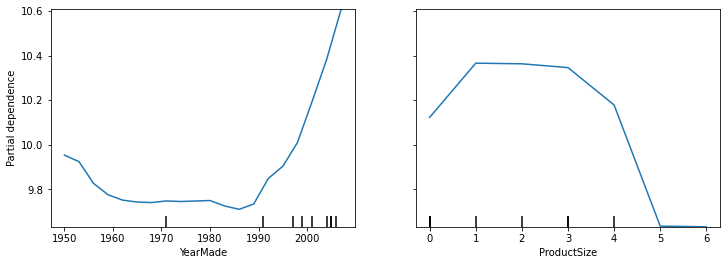

In [108]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

Si l'on examine tout d'abord le graphique "YearMade", et plus précisément la partie couvrant les années après 1990 (puisque, comme nous l'avons noté, c'est là que nous disposons du plus grand nombre de données), on peut constater une relation presque linéaire entre l'année et le prix.

N'oubliez pas que nous avons pris le logarithme du prix de vente, ce qui signifie qu'en pratique, il y a une augmentation exponentielle du prix. C'est ce à quoi on peut s'attendre : la dépréciation est généralement reconnue comme un facteur multiplicatif dans le temps, de sorte que, pour une date de vente donnée, la variation du prix de vente en fonction de l'année de fabrication devrait montrer une relation exponentielle.

Le graphique de ProductSize est un peu plus préoccupant. Il montre que le dernier groupe, auquel nous avons affecté les nombreuses lignes avec des valeurs manquantes, a le prix le plus bas. 

Pour poursuivre l'analyse sur ce constat, nous voudrions savoir pourquoi cette valeur manque si souvent dans les données, et ce que cela signifie. Les valeurs manquantes peuvent parfois être des prédicteurs utiles - cela dépend entièrement de la raison pour laquelle elles ne sont pas présentes. 

Parfois, cependant, elles peuvent indiquer une **fuite d'information**.

### Fuite d'information - Data Leakage

Dans la publication "Leakage in Data Mining: Formulation, Detection, and Avoidance", Shachar Kaufman, Saharon Rosset, et Claudia Perlich décrivent les **fuites d'information** comme :
    
    L'introduction d'informations sur la cible d'un problème de data mining, qui ne devraient pas être légitimement disponibles au moment de l'extraction.

Un exemple trivial de fuite serait un modèle qui utilise la cible elle-même comme caractéristique en entrée, concluant par exemple qu'"il pleut les jours de pluie". 

Dans la pratique, l'introduction de ces informations illégitimes est involontaire et facilitée par le processus de collecte, d'agrégation et de préparation des données.

Un exemple plus réaliste serait une base de données de personnes connues de l'entreprise, sur laquelle on doit créer un modèle pour identifier les prospects d'aujourd'hui les plus suceptibles de devenir clients de l'entreprise demain. Chaque personne a une colonne avec la date de dernière mise à jour de ses données personnelles. Pour les clients de l'entreprise, on recalcule un score de rentabilité tous les dimanches soir. Evidemment, ce score n'est pas inclus dans les données fournies pour entrainer le modèle, mais par erreur la date de dernière mise à jour se trouve embarquée dans l'export de données réalisées. Toutes les personnes avec une dernière date de modification correspondant à un dimanche soir auront alors une forte chance de devenir des clients ...

La fuite d'informations est subtile et peut prendre de nombreuses formes. En particulier, les valeurs manquantes représentent souvent une fuite de données.

Les approches les plus pratiques et les plus simples pour identifier les fuites de données consistent à construire un modèle et ensuite :

1. Vérifier si la précision du modèle est trop bonne pour être vraie.
2. Rechercher les prédicteurs importants qui n'ont pas de sens dans la pratique.
3. Chercher des résultats de tracés de dépendance partielle qui n'ont pas de sens dans la pratique.

### Tree Interpreter

Nous avons déjà vu comment calculer l'importance des caractéristiques dans l'ensemble de la forêt aléatoire. L'idée de base était d'examiner la contribution de chaque variable à l'amélioration du modèle, à chaque branche de chaque arbre, puis d'additionner toutes ces contributions par variable.

Nous pouvons faire exactement la même chose, mais pour une seule ligne de données. 

Par exemple, disons que nous examinons un engin particulier lors d'une vente aux enchères. Notre modèle pourrait prévoir que cet article sera très cher, et nous voulons savoir pourquoi. Nous prenons donc cette ligne de données et nous la faisons passer dans le premier arbre de décision, en regardant quelle variable est utilisée à chaque point de décision de l'arbre. Pour chaque division en deux branches, nous voyons quelle est l'augmentation ou la diminution du prix de vente par rapport au nœud parent de l'arbre. Nous faisons cela pour chaque arbre, et nous additionnons le changement total par variable.

In [117]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [118]:
row = valid_xs_final.iloc[:5]

In [119]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [120]:
prediction[0], bias[0], contributions[0].sum()

(array([10.0104191]), 10.104446629688008, -0.09402752543267534)

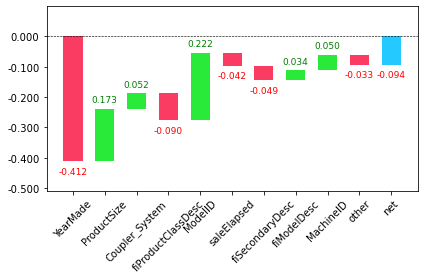

In [121]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

Ce type d'information est surtout utile en production, plutôt que pendant l'élaboration du modèle. Vous pouvez l'utiliser pour fournir des explications aux utilisateurs de votre application sur le raisonnement sous-jacent des prévisions.

Maintenant que nous avons abordé quelques techniques classiques d'apprentissage machine pour résoudre ce problème, voyons comment le deep learning peut nous aider à aller plus loin sur cet exemple.

## Extrapolation et Réseaux de neurones

On vient de voir que les arbres de décision ont toutes les qualités du monde ... mais ils ont aussi une limitation importante dont nous devons prendre conscience maintenant.

### Le problème de l'extrapolation avec des arbres de décision

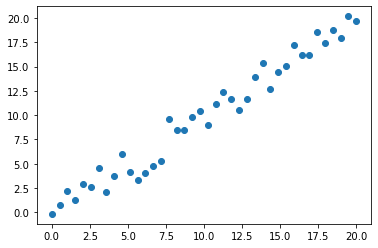

In [122]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [123]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [124]:
xs_lin_train, y_lin_train = xs_lin[:30],y_lin[:30]
xs_lin_valid, y_lin_valid = xs_lin[30:],y_lin[30:]

In [125]:
m_lin = RandomForestRegressor().fit(xs_lin_train,y_lin_train)

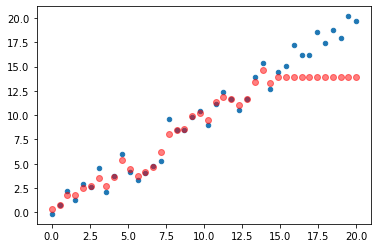

In [126]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

Ooops, que c'est-il passé ?

Une random forest ne peut prédire qu'une des valeurs moyennes des groupes d'exemples de données vues à l'entrainement dans chacune des feuilles de l'arbre de décision.

**!!! Limitation très importante : une random forest ne peut extrapoler la tendance d'une courbe pour réaliser des prédictions dans un domaine de valeurs jamais vu à l'entrainement !!!**

C'est particulièrement problématique pour les données où il existe une tendance dans le temps, comme l'inflation, et que vous souhaitez faire des prévisions pour un temps futur... Vos prévisions seront systématiquement trop basses.

Mais le problème va au-delà des variables temporelles. Les forêts aléatoires ne sont pas capables d'extrapoler en dehors des types de données qu'elles ont vues à l'entrainement, dans un sens plus général. C'est pourquoi nous devons nous assurer que notre jeu de validation ne contient pas de données hors domaine.

### Identifier les données Hors Domaine (par rapport au jeu d'entrainement)

Astuce : 

1. Entrainer un modèle à prédire si les données font partie du jeu d'entrainement ou du jeu de validation
2. Si on y parvient celà signifie que les données du jeu de validation ont bien des propriétés distinctes du jeu d'entrainement
3. Examiner les caractéristiques qui ont permis au modèle d'identifier les données du jeu de validation

In [127]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.576643
17,saleDayofyear,0.329776
10,SalesID,0.075615
11,MachineID,0.015996
13,Hydraulics,0.000612
9,Enclosure,0.000524


On voit qu'il existe trois colonnes qui diffèrent sensiblement entre les jeux d'entrainement et de validation : saleElapsed, SalesID et MachineID. La raison pour laquelle c'est le cas pour saleElapsed est assez évidente : il s'agit du nombre de jours entre le début du jeu de données et chaque ligne, donc il encode directement la date. L'importance de SalesID et MachineID suggère que les identifiants des ventes aux enchères sont également incrémentés dans le temps. 

Obtenons une baseline de l'erreur RMSE du modèle de forêt aléatoire original, puis voyons quel est l'effet de la suppression de chacune de ces colonnes à tour de rôle :

In [128]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.23652
SalesID 0.234057
saleElapsed 0.242377
MachineID 0.235141


Il semble que nous devrions être en mesure de supprimer SalesID et MachineID sans perdre en performance. Vérifions :

In [129]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.233486

La suppression de ces variables a légèrement amélioré la précision du modèle, mais surtout, elle devrait le rendre plus résistant dans le temps et plus facile à maintenir et à comprendre. Nous recommandons que pour tous les jeux de données, vous essayiez de construire un modèle pour prédire la colonne "is_valid", comme nous l'avons fait ici. Cela permet souvent de découvrir des problèmes subtils de changements de domaine de valeurs que vous risqueriez sinon de ne pas voir.

Dans notre cas, une chose qui pourrait également aider est d'éviter simplement d'utiliser des données trop anciennes. Souvent, les données trop anciennes montrent des relations qui ne sont tout simplement plus valables. Essayons de n'utiliser que les données des années les plus récentes :

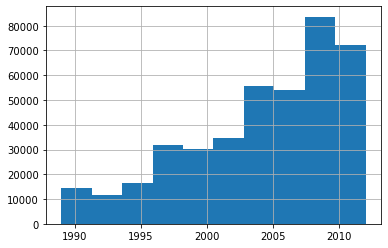

In [130]:
xs['saleYear'].hist();

In [131]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [132]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.168199, 0.23169)

Vérifions le classement de la compétition Kaggle et voyons comment notre modèle se serait classé ?

https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard

=> n°6 ! Pas mal, mais on peut encore améliorer un peu.

### Utiliser un réseau de neurone

In [133]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [134]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Les colonnes de type catégorie sont traitées très différemment dans les réseaux de neurones, par rapport aux approches par arbre de décision.

Nous allons les représenter par des embeddings comme nous l'avons vu dans la session précédente.

In [139]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

Dans ce cas, cependant, il y a une variable que nous ne voulons absolument pas considérer comme catégorique : la variable saleElapsed. Une variable de type catégorie ne peut, par définition, pas extrapoler en dehors de la fourchette de valeurs qu'elle a vue à l'entrainement, mais nous voulons pouvoir prédire les prix de vente aux enchères à l'avenir. C'est pourquoi nous devons en faire une variable continue :

In [140]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [141]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
Hydraulics              12
ProductGroup             6
Travel_Controls          7
Drive_System             4
saleDayofyear          361
dtype: int64

Le fait qu'il existe deux variables relatives au "modèle" de l'équipement, toutes deux présentant de très hautes cardinalités similaires, suggère qu'elles peuvent contenir des informations similaires et redondantes. 

Notez que nous ne voyons pas nécessairement cela lors de l'analyse des caractéristiques redondantes, puisque cela repose sur le fait que des variables similaires soient triées dans le même ordre (c'est-à-dire qu'elles doivent avoir des niveaux nommés de manière similaire). 

Avoir une colonne avec 5 000 niveaux signifie avoir besoin de 5 000 colonnes dans notre matrice d'embeddings, ce qu'il serait bon d'éviter si possible. 

Voyons l'impact de la suppression d'une de ces colonnes modèles sur la forêt aléatoire :

In [143]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.169963, 0.235342)

In [144]:
cat_nn.remove('fiModelDescriptor')

Nous pouvons créer notre objet TabularPandas de la même manière que lorsque nous avons créé notre forêt aléatoire, avec un ajout très important : la normalisation. 

Une forêt aléatoire n'a pas besoin de normalisation - la procédure de construction de l'arbre ne s'intéresse qu'à l'ordre des valeurs d'une variable, pas du tout à la façon dont elles sont mises à l'échelle. 

Mais comme nous l'avons vu, c'est important pour un réseau de neurones qui travaille directement sur les valeurs. Par conséquent, nous ajoutons la transformation Normalize lorsque nous construisons notre objet TabularPandas.

In [145]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [146]:
dls = to_nn.dataloaders(1024)

In [147]:
y = to_nn.train.y
y.min(),y.max()

(8.465899897028686, 11.863582336583399)

In [148]:
from fastai2.tabular.all import *

Par défaut, pour les données tabulaires, fastai crée un réseau de neurones avec deux couches cachées, avec respectivement 200 et 100 activations. Cela fonctionne assez bien pour les petits ensembles de données, mais ici nous avons un ensemble de données assez important, donc nous augmentons la taille des couches à 500 et 250 :

In [153]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0002754228771664202)

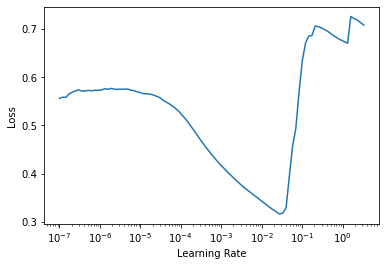

In [150]:
learn.lr_find()

In [154]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.066197,0.068307,00:11
1,0.052773,0.063322,00:11
2,0.046888,0.055548,00:11
3,0.041107,0.054609,00:11
4,0.036872,0.053436,00:11


In [155]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.231163

In [156]:
learn.save('nn')

### Ensembling

Repensez au raisonnement initial qui explique pourquoi les forêts aléatoires fonctionnent si bien : chaque arbre a des erreurs, mais ces erreurs ne sont pas corrélées entre elles, de sorte que la moyenne de ces erreurs devrait tendre vers zéro une fois qu'il y a suffisamment d'arbres. Un raisonnement similaire pourrait être utilisé pour envisager de faire la moyenne des prédictions des modèles entrainés à l'aide de différents algorithmes.

Dans notre cas, nous avons deux modèles très différents, entrainés à l'aide d'algorithmes très différents : une forêt aléatoire et un réseau de neurones. Il serait raisonnable de s'attendre à ce que les types d'erreurs que chacun d'entre eux commet soient très différents. Par conséquent, on pourrait s'attendre à ce que la moyenne de leurs prévisions soit meilleure que les prévisions individuelles de chacun.

Comme nous l'avons vu précédemment, une forêt aléatoire est elle-même un ensemble. Mais nous pouvons alors inclure une forêt aléatoire dans un autre ensemble - un ensemble de la forêt aléatoire et du réseau de neurones ! Bien que la technique d'ensembling ne fasse pas la différence entre un processus de modélisation réussi ou non, elle peut certainement donner un petit coup de pouce aux modèles que vous avez construits.

Un point mineur dont nous devons être conscients est que notre modèle PyTorch et notre modèle Sklearn créent des données de types différents : PyTorch nous donne un tenseur de rang 2 (c'est-à-dire une matrice de colonnes), tandis que NumPy nous donne un tableau de rang 1 (un vecteur).

In [157]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [158]:
r_mse(ens_preds,valid_y)

0.224075

Vérifions le classement de la compétition Kaggle et voyons comment notre modèle se serait classé ?

https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard

=> n°1 !

### Boosting

Jusqu'à présent, notre approche de création d'ensemble a consisté à utiliser **le bagging**, qui consiste à combiner plusieurs modèles (chacun étant entrainé sur un sous-ensemble de données différent) en faisant la moyenne. Comme nous l'avons vu, lorsque cette méthode est appliquée aux arbres de décision, on parle de forêt aléatoire.

Il existe une autre approche importante de création d'ensemble, appelée **boosting**, qui consiste à ajouter des modèles les uns aux autres au lieu d'en faire la moyenne. Voici comment fonctionne le boosting :

1. Entrainez un petit modèle, qui aura du mal à s'ajuster complètement à votre jeu de données.
2. Calculez les prédictions de ce modèle sur le jeu d'entrainement.
3. Soustrayez les prédictions des cibles ; on obtient des "résidus" qui représentent l'erreur pour chaque point de l'ensemble d'entraînement à ce stade.
4. Revenez à l'étape 1, mais au lieu d'utiliser les cibles initiales, utilisez les résidus comme cibles pour l'entraînement.
5. Continuez ainsi jusqu'à ce que vous atteigniez un critère d'arrêt, tel qu'un nombre maximum d'arbres, ou que vous observiez l'aggravation de votre erreur de validation.

En utilisant cette approche, chaque nouvel arbre tentera d'ajuster l'erreur de tous les arbres précédents combinés. Comme nous créons continuellement de nouveaux résidus, en soustrayant les prédictions de chaque nouvel arbre des résidus de l'arbre précédent, les résidus deviendront de plus en plus petits.

Pour faire des prédictions avec un ensemble d'arbres **boostés**, nous calculons les prédictions de chaque arbre, puis nous les additionnons toutes. 

Il existe de nombreux modèles suivant cette approche de base, et de nombreux noms pour les mêmes modèles. Gradient Boosted Machines (GBM) et Gradient Boosted Decision Trees (GBDT) sont les termes que vous êtes le plus susceptible de rencontrer, ou vous pouvez voir les noms des bibliothèques spécifiques qui les mettent en œuvre ; au moment de la rédaction de ce document, XGBoost est la plus populaire.

Notez que, contrairement aux forêts aléatoires, cette approche n'empêche pas l'overfitting. L'utilisation de plus d'arbres dans une forêt aléatoire n'entraîne pas d'pverfitting, car chaque arbre est indépendant des autres. Mais dans un ensemble boosté, plus vous avez d'arbres, plus l'erreur sur le jeu d'entraînement diminue, et vous finirez par constater une sur-spécialisation sur le jeu de validation.

Nous n'allons pas entrer dans les détails de l'entrainement d'un gradient boosted tree ensemble ici, parce que le domaine évolue rapidement, et toutes les indications que nous donnons seront presque certainement dépassées au moment où vous lirez ceci. Au moment où nous écrivons ces lignes, sklearn vient d'ajouter une classe HistGradientBoostingRegressor qui offre d'excellentes performances. Il y a de nombreux hyperparamètres à ajuster pour cette classe, comme pour toutes les méthodes similaires que nous avons vues. Contrairement aux forêts aléatoires, les gradient boosted trees sont extrêmement sensibles aux choix de ces hyperparamètres ; en pratique, la plupart des gens utilisent une boucle qui essaie une gamme de différents hyperparamètres pour trouver ceux qui fonctionnent le mieux.

### Combiner les Embeddings avec d'autres méthodes

Que se passe-t-il si vous entraînez d'abord un réseau de neurones avec des embeddings pour représenter les catégories, puis que vous utilisez les embeddings de catégories récupérés en fin d'apprentissage comme caractéristiques d'entrée de modèles de machine learning classiques ?

**Dans tous les cas, les modèles de machine learning classiques sont considérablement améliorés en utilisant les embeddings au lieu des catégories brutes.**

C'est un résultat vraiment important, car il montre que vous pouvez obtenir une grande partie de l'amélioration des performances d'un réseau de neurones sans avoir à utiliser un réseau de neurones au moment de l'inférence. Vous pourriez simplement utiliser un embedding, qui n'est littéralement qu'un dictionnaire de valeurs pour les niveaux de chaque catégorie, avec un petit ensemble d'arbres de décision.

Ces embeddings ne doivent même pas nécessairement être appris séparément pour chaque modèle ou tâche dans une organisation. Au lieu de cela, une fois qu'un ensemble d'embeddings est appris pour une colonne pour une tâche donnée, ils peuvent être stockés dans un endroit central et réutilisés dans plusieurs modèles. En fait, nous savons, grâce à des communications privées avec d'autres praticiens de grandes entreprises, que cela se produit déjà dans de nombreux endroits.

## Conclusion: Recommandations pour la modélisation de données structurées

Nous avons discuté de deux approches pour la modélisation de données tabulaires : les ensembles d'arbres de décision et les réseaux de neurones. Nous avons également évoqué deux ensembles d'arbres de décision différents : les random forests et les gradient boosting machines. Chacune est très efficace, mais chacune comporte aussi des compromis :

Les random forests sont les plus faciles à entrainer, car elles sont extrêmement résistantes aux choix d'hyperparamètres et nécessitent très peu de prétraitements. Elles sont très rapides à entraîner, et ne devraient pas poser de problème d'overfitting si vous avez suffisamment d'arbres. Mais elles peuvent être un peu moins précises, surtout si une extrapolation est nécessaire, comme la prévision de périodes futures.

En théorie, les gradient boosting machines sont aussi rapides à entraîner que les forêts aléatoires, mais en pratique, vous devrez essayer de nombreux hyperparamètres différents. Elles peuvent conduire à des problématiques d'overfitting, mais elles sont souvent un peu plus précises que les forêts aléatoires.

Les réseaux neuronaux sont les plus longs à entrainer et nécessitent un prétraitement supplémentaire, tel que la normalisation ; cette normalisation doit également être utilisée au moment de l'inférence. Ils peuvent donner de très bons résultats et permettent de bien extrapoler, mais seulement si vous faites attention à vos hyperparamètres et si vous prenez soin d'éviter l'overfitting.

Nous vous suggérons de commencer votre analyse par une random forest. Cela vous donnera une base de référence solide, et vous pouvez être sûr que c'est un point de départ raisonnable. Vous pouvez ensuite utiliser ce modèle pour la sélection des caractéristiques et l'analyse des dépendances partielles, afin de mieux comprendre vos données.

À partir de cette base, vous pouvez essayer les réseaux neuronaux et les GBM, et s'ils vous donnent des résultats nettement meilleurs sur votre ensemble de validation dans un délai raisonnable, vous pouvez les utiliser. 

Si les ensembles d'arbres de décision fonctionnent bien pour vous, essayez d'ajouter aux données les embeddings des variables catégorielles apprises à l'aide d'un réseau de neurones, et voyez si cela aide vos arbres de décision à mieux apprendre.